## 下载环境

## 下载数据集

from datasets import load_dataset

ds = load_dataset("FreedomIntelligence/huatuo26M-testdatasets",cache_dir='./')

## 数据处理

注意；执行下面代码之前一定要开学术加速 source /etc/network_turbo


In [ ]:
import transformers
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import mine_hard_negatives
transformers.utils.import_utils._TORCH_GREATER_EQUAL_2_6 = True  

dataset = load_dataset("FreedomIntelligence/huatuo26M-testdatasets",cache_dir='./')

# split_dataset = dataset["test"].train_test_split(test_size=0.05, seed=42)

# # 输出划分后的数据集信息
# print("划分后的数据集:", split_dataset)
# print(f"训练集大小: {len(split_dataset['train'])}")
# print(f"测试集大小: {len(split_dataset['test'])}")

# 加载小的embeding模型
model_path = "./m3e"

# 下载模型到指定目录
embedding_model = SentenceTransformer(
    "moka-ai/m3e-small",
    cache_folder=model_path,  # 关键参数：强制下载到指定路径
)

train_dataset = dataset['test']

#挖掘难负样本
hard_train_dataset = mine_hard_negatives(
    train_dataset,
    embedding_model,
    anchor_column_name="questions",
    positive_column_name="answers",
    num_negatives=5,  # How many negatives per question-answer pair
    range_min=20,  # Skip the x most similar samples
    range_max=50,  # Consider only the x most similar samples
    max_score=0.8,  # Only consider samples with a similarity score of at most x
    absolute_margin=0.1,  # Similarity between query and negative samples should be x lower than query-positive similarity
    sampling_strategy="top",  # Randomly sample negatives from the range
    batch_size=64,  # Use a batch size of 4096 for the embedding model
    output_format="labeled-list",  
    use_faiss=True,  # Using FAISS is recommended to keep memory usage low (pip install faiss-gpu or pip install faiss-cpu)
)

def convert_format(example):
    # 获取正确答案和被拒绝的答案
    correct_response = next(resp for resp, label in zip(example['answers'], example['labels']) if label == 1)
    rejected_responses = [resp for resp, label in zip(example['answers'], example['labels']) if label == 0]
    return {
        "query": example['questions'],
        "response": correct_response,
        "rejected_response": rejected_responses
    }
# 数据格式转换
transformed_dataset = hard_train_dataset.map(convert_format, remove_columns=hard_train_dataset.column_names)
transformed_dataset.to_json("./data_hub/qwen3_emb.json",force_ascii=False)


### 报错

ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.

## 使用的loss函数为InfoNCE Loss

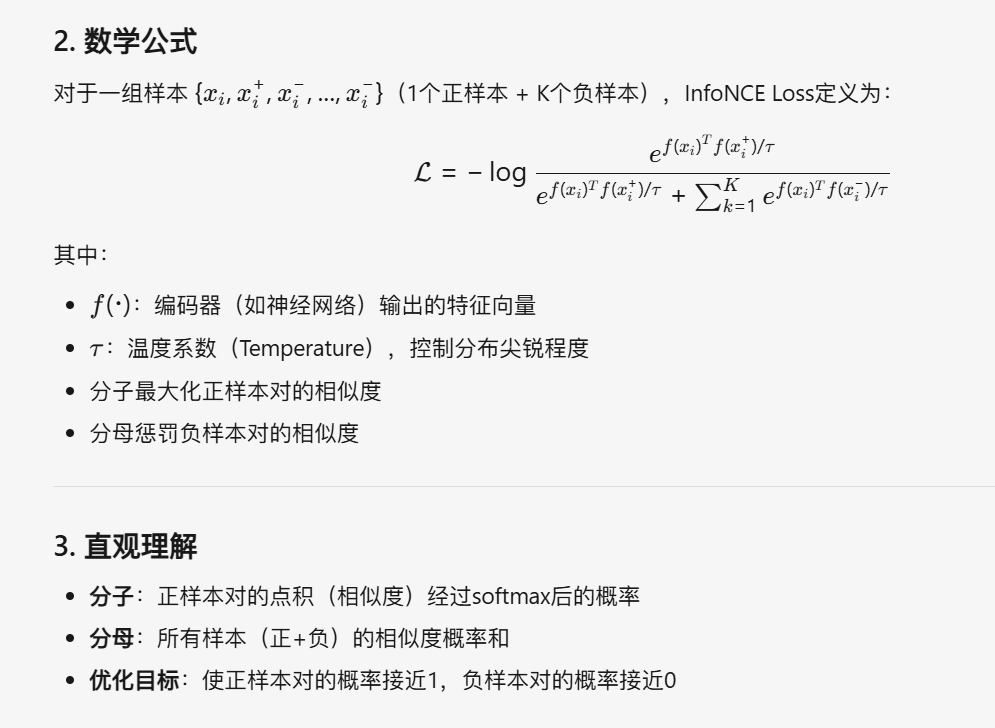

## 训练命令

### web-ui

### 命令行

## 测试

In [ ]:
# Requires transformers>=4.51.0
import torch
import torch.nn.functional as F

from torch import Tensor
from modelscope import AutoTokenizer, AutoModel


def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]


def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery:{query}'

# Each query must come with a one-sentence instruction that describes the task
task = 'Given a web search query, retrieve relevant passages that answer the query'

# queries = [
#     get_detailed_instruct(task, 'What is the capital of China?'),
#     get_detailed_instruct(task, 'Explain gravity')
# ]
# # No need to add instruction for retrieval documents
# documents = [
#     "The capital of China is Beijing.",
#     "Gravity is a force that attracts two bodies towards each other. It gives weight to physical objects and is responsible for the movement of planets around the sun."
# ]


queries = [
    get_detailed_instruct(task, '没有病史，今天做血常规检查，发现尿素氮偏低，请问:有问题吗？想得到的帮助：只是咨询，需要平时生活中注意什么？'),
    get_detailed_instruct(task, '后背皮肤发黑怎么回事？')
]
# No need to add instruction for retrieval documents
documents = [
    "你好，根据你的检查情况，尿素氮偏低，一般是没有什么问题的。尿素氮偏高才有临床意义的，是肾功能的一项主要检测指标。偏低一般和饮食有关，建议多补充含蛋白食物",
    "你好，根据你的症状平时可以吃点金贵肾气丸调理一下，平常注意保暖,尤其不要熬夜平时多喝水，少吃草酸盐含量高的食物，比如菠菜，甜菜等，少吃豆制品，豆制品含草酸盐和磷酸盐都高",
    "你好，根据你描述的情况来看，后背皮肤发黑可能是黑色素沉积造成的，建议你不要担心，平时需要保持心情舒畅，放松心情，多喝水，多吃水果蔬菜，多运动增强免疫力。",
    "指导意见：可能与体内的性激素水平有关，或者由于局部皮肤干燥引起。建议经常清洁乳头，并涂于润肤乳。若不放心，也可到医院查明原因，对症治疗。"
]
input_texts = queries + documents

# tokenizer = AutoTokenizer.from_pretrained('/root/autodl-tmp/Qwen/Qwen3-Embedding-4B', padding_side='left')
tokenizer = AutoTokenizer.from_pretrained('/root/autodl-tmp/Qwen/merged_model', padding_side='left')
# model = AutoModel.from_pretrained('/root/autodl-tmp/Qwen/Qwen3-Embedding-4B')

# We recommend enabling flash_attention_2 for better acceleration and memory saving.
# model = AutoModel.from_pretrained('/root/autodl-tmp/Qwen/Qwen3-Embedding-4B', attn_implementation="flash_attention_2", torch_dtype=torch.float16, device_map="cuda" )
model = AutoModel.from_pretrained('/root/autodl-tmp/Qwen/merged_model', attn_implementation="flash_attention_2", torch_dtype=torch.float16, device_map="cuda" )

max_length = 8192

# Tokenize the input texts
batch_dict = tokenizer(
    input_texts,
    padding=True,
    truncation=True,
    max_length=max_length,
    return_tensors="pt",
)
batch_dict.to(model.device)
outputs = model(**batch_dict)
embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T)
print(scores.tolist())